# Trabajo Práctico 0: Generar datos en Python

Primero, importaremos las librerías necesarias para el código


In [1]:
import pandas as pd
import numpy as np

## Ejercicio 1

Una distribución normal de $d$ variables con centro en $\mu \in \mathbb{R}^n$ y matriz de covarianza $V = \begin{bmatrix} \sigma_1^2 & 0 & \dots & 0 \\ 0 & \sigma_2^2 & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & \sigma_d^2\end{bmatrix}$

es equivalente a $d$ variables independientes $x_i$ distribuidas normalmente, con centro en $\mu_i$ y desviación estándar $\sigma_i$ respectivamente. Usaremos esto para nuestra implementación.

En nuestro caso, cada variable $x_i$ será una variable con centro en $1$ o $-1$ y desviación estándar $C * \sqrt{d}$, dependiendo de la clase a la que pertenece cada punto.

Generaremos $\lfloor\frac{n}{2}\rfloor$ puntos de clase 0 y $n - \lfloor\frac{n}{2}\rfloor$ de clase 1. Una vez que creamos el `DataFrame`, reordenamos aleatoriamente los puntos para no tener a todos los puntos de la misma clase contiguos.

In [2]:
def ej1(d, n, C):
  df = pd.DataFrame(np.random.normal(-1, C * np.sqrt(d), (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en -1 cada una
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(1, C * np.sqrt(d), (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en 1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

Podemos llamar a esta función para pedir puntos de dimensión $2$, los cuales podemos graficar para ver si se corresponde con las distribuciones que queríamos.

<Axes: xlabel='0', ylabel='1'>

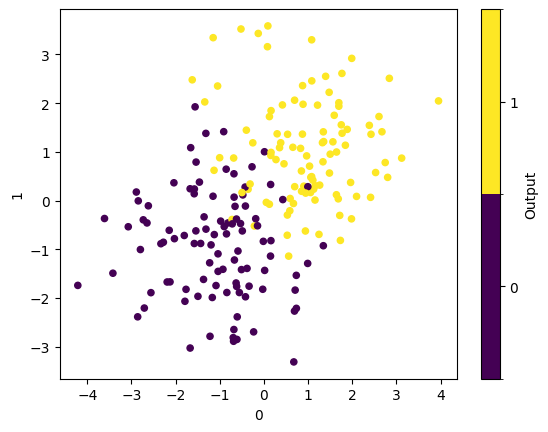

In [3]:
ej1(2, 200, 0.75).plot.scatter(x=0, y=1, c="Output", cmap="viridis")

Por último, veamos que las medias y desviaciones estándar sean correctas.

In [4]:
test = ej1(4, 5000, 2).groupby("Output")
display(test.mean()) # Medias de cada clase
display(test.std()) # Desviación estándar de cada clase

,0,1,2,3
Output,,,,
0,-1.013630,-1.002071,-1.201666,-1.013965
1,0.996691,0.936445,1.037410,0.985382


,0,1,2,3
Output,,,,
0,3.893324,4.133122,4.045894,3.990179
1,3.886428,3.972389,3.941273,4.032252


## Ejercicio 2

El código es muy similar al del ejercicio 1, pero los vectores sobre los cuales debemos centrar nuestra distribución no tienen todas sus componentes iguales, por lo cual debemos centrar cada llamada a `np.random.normal` en un valor diferente, según la componente del vector que estemos generando.

In [5]:
def ej2(d, n, C):
  v0 = [-1] + [0] * (d - 1)
  v1 = [1] + [0] * (d - 1)
  df = pd.DataFrame(np.random.normal(v0, [C] * d, (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en la componente correspondiente de v0
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(v1, [C] * d, (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en v1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

Veamos el gráfico de las clases para ver si corresponden con lo esperado.

<Axes: xlabel='0', ylabel='1'>

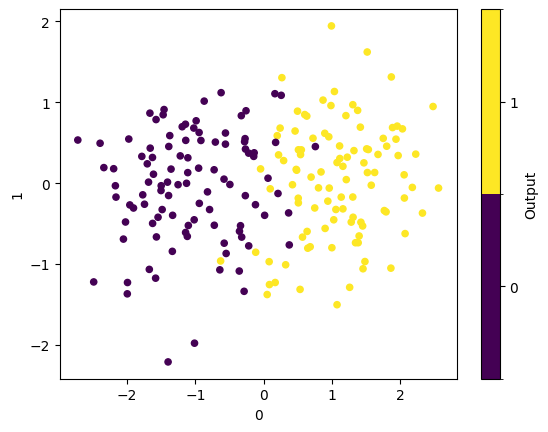

In [6]:
ej2(2, 200, 0.75).plot.scatter(x=0, y=1, c="Output", cmap="viridis")

Y nuevamente, comprobemos las medias y las desviaciones estándar.

In [7]:
test = ej2(4, 5000, 2).groupby("Output")
display(test.mean()) # Medias de cada clase
display(test.std()) # Desviación estándar de cada clase

,0,1,2,3
Output,,,,
0,-1.050073,0.021258,0.037574,0.009103
1,1.008374,-0.045369,-0.018271,0.049170


,0,1,2,3
Output,,,,
0,2.032093,1.984794,1.965201,2.004508
1,1.993926,1.970684,2.018521,1.993217


## Ejercicio 3
Es un resultado bastante famoso que para conseguir puntos uniformemente distribuidos sobre el círculo unitario podemos generar 2 variables uniformemente distribuidas $\rho$ y $\theta$ entre $0$ y $1$ para sus coordenadas polares, y tomar el punto $(\sqrt{\rho}, 2 \pi \theta)$ (y pasarlo de polares a cartesianas). Crearemos una función auxiliar que genere estos puntos en polares, y otra para pasarlos a cartesianas, para mayor conveniencia.

In [8]:
def rand_polar_in_unit_circle():
  return (np.sqrt(np.random.uniform()), 2 * np.pi * np.random.uniform())

def polar_to_cartesian(rho, theta):
  return { "x": rho * np.cos(theta), "y": rho * np.sin(theta) }

Veamos que esto genera puntos uniformes en un círculo.

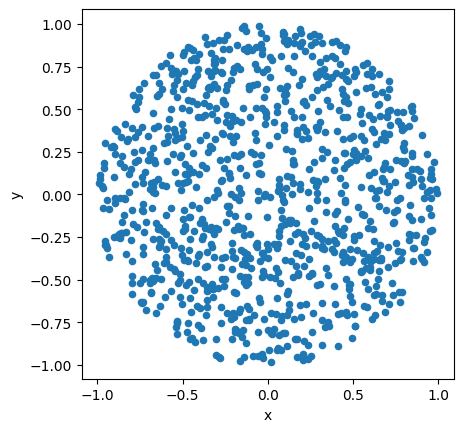

In [9]:
pd.DataFrame([polar_to_cartesian(*rand_polar_in_unit_circle()) for _ in range(1000)]).plot.scatter(x="x", y="y").set_aspect('equal')

Ahora sí, creamos la función para generar los puntos pertenecientes a las 2 clases.

Notemos primero que las curvas están dadas por las ecuaciones $\rho = \frac{\theta}{4\pi}$ y $\rho = \frac{\theta + \pi}{4\pi}$ respectivamente. Entonces, para saber si un ángulo está en la curva, bastaría con comprobar que:

$$ \frac{\theta}{4\pi} < \rho < \frac{\theta + \pi}{4\pi}$$

Estas ecuaciones no tienen en cuenta que nuestros valores para $\theta$ solo aumentan hasta $2\pi$ y luego vuelven a $0$. Es por eso que deberíamos probar con todos los ángulos equivalentes al $\theta$ de cada punto, y no sólo el valor que está entre $0$ y $2\pi$. Supongamos que queremos ver si $\rho$ está entre $\frac{\theta + 2\pi}{4\pi}$ y $\frac{\theta + \pi + 2\pi}{4\pi}$. Tenemos:

$$ \frac{\theta + 2\pi}{4\pi} < \rho < \frac{\theta + \pi + 2\pi}{4\pi}$$
$$ \frac{\theta}{4\pi}\frac{1}{2} < \rho < \frac{\theta + \pi}{4\pi}\frac{1}{2}$$
$$ \frac{\theta}{4\pi} < \rho - \frac{1}{2} < \frac{\theta + \pi}{4\pi}$$

Es decir, que sumar $2\pi$ a $\theta$ es equivalente a restar $\frac{1}{2}$ a $\rho$ para ver si está dentro de la curva. Usaremos esto en nuestro algoritmo, ya que si eligiéramos sumar $2\pi$ cada vez, cuando tuvieramos un punto fuera de la curva no sabríamos cuando parar de intentar con valores de $\theta$ cada vez más grandes. En cambio, si optamos por restarle a $\rho$, sabemos que siempre podremos parar cuando $\rho < 0$ ya que no tendría sentido hablar de radios negativos en este caso.

Una vez tenemos una forma de distinguir si un punto está entre las curvas o no, el resto de la implementación es sencilla. Ya que el enunciado exige una cantidad especifica de puntos de cada clase, lo que haremos es generar puntos al azar en el círculo hasta cumplir con la cantidad requerida de cada clase. La implementación final es la siguiente.

In [29]:
def ej3(n):
  def is_between_curves(r, t): # Función para comprobar si ciertas coordenadas polares corresponden a un punto dentro de la curva (Clase 0)
    result = False
    while not result and r > 0: # Como nuestros ángulos van hasta 2pi, hay que restar iterativamente una 'vuelta completa' para ver si el punto está en la curva
      result = (t / (4 * np.pi)) <= r and r < ((t + np.pi) / (4 * np.pi))
      r -= 0.5
    return result

  vals = []
  while len(vals) < n//2:
    x = rand_polar_in_unit_circle()
    if(is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 0})

  while len(vals) < n:
    x = rand_polar_in_unit_circle()
    if(not is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 1})

  df = pd.DataFrame(vals)
  df.Output = df["Output"].astype('category')
  return df

Veamos que genera un gráfico similar al del enunciado, que es lo que esperamos.

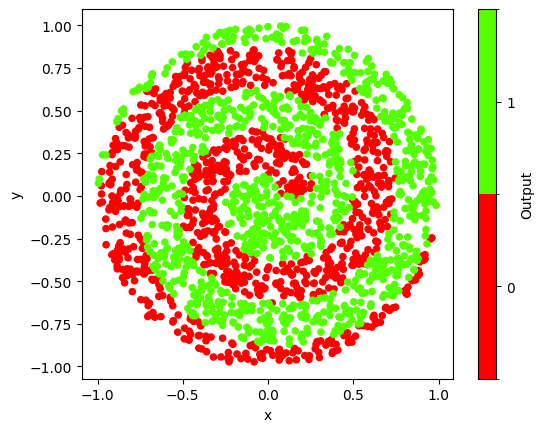

In [32]:
ej3(2000).plot.scatter(x="x", y="y", c="Output", cmap="prism").set_aspect('equal')